In [199]:
import pickle
import numpy as np
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from skimage import measure
from skimage.morphology import label
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy.spatial.distance import euclidean


In [200]:
conv = defaultdict(list)
not_conv = defaultdict(list)
boom = defaultdict(list)


for i in glob('../*'):
    try:
        j = int(i.split('_')[-1])
        with open(i, 'rb') as inp:
            a = pickle.load(inp)
        if a.eps != 0.00001:
            continue
        if a.converged != 'boom':
            conv[(a.q, a.du)].append(a)
        elif a.converged == 'boom':
            boom[(a.q, a.du)].append(a)      
    except:
        pass

In [201]:
def u(exp):
    return 1
def v(exp):
    return 1
def f_u(exp):
    return - v(exp)
def f_v(exp):
    return - u(exp)
def g_u(exp):
    return exp.p*v(exp)
def g_v(exp):
    return exp.p*(u(exp) - (exp.q*(exp.q+1))/(exp.q+v(exp))**2)

def calc_ks(exp):
    a = exp.du*exp.dv
    b =  - (exp.dv*f_u(exp) + exp.du*g_v(exp))
    c = f_u(exp)*g_v(exp) - f_v(exp)*g_u(exp)
    d = b**2 -4*a*c
    k0 = (-b - np.sqrt(d)) / (2*a)    
    k1 = (-b + np.sqrt(d)) / (2*a)
    return k0, k1

Text(189.72222222222223, 0.5, '$q$')

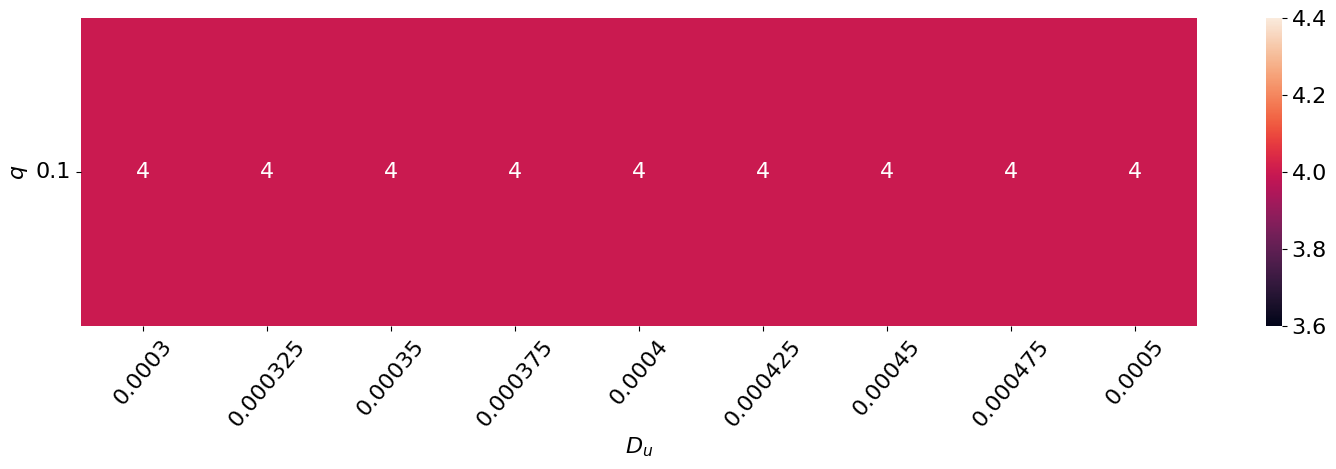

In [202]:
qs = sorted(set(k[0] for k in conv))
dus = sorted(set(k[1] for k in conv))

res = np.zeros((len(qs), len(dus)))

for q,du in conv: 
    res[ qs.index(q), dus.index(du)] += len(conv[(q,du)])
plt.figure(figsize=(18,4))
ax = sns.heatmap(res, annot=True)
_ = ax.set_xticklabels(dus, rotation=50)
ax.set_xlabel('$D_u$')
ax.invert_yaxis()
_ = ax.set_yticklabels(qs, rotation=0)
ax.set_ylabel('$q$')

In [203]:

import matplotlib.patches as mpatches
def get_bin_map(exp):
    bin_map = exp.process_U[-1]
    return bin_map > np.quantile(bin_map,0.75)

def get_regions(exp):
    bin_map = get_bin_map(exp)
    labeled_array, num_features = label(bin_map, return_num=True)

    # Measure properties of labeled regions
    return measure.regionprops(labeled_array)

def get_contours(exp):
    bin_map = get_bin_map(exp)

    # Measure properties of labeled regions
    return measure.find_contours(bin_map, fully_connected='high')

def create_graph_from_mask(mask):
    """
    Create a graph from a segmentation mask. 
    Here, an edge is added between neighboring pixels within the object.
    For simplicity, using 4-connectivity.
    """

    G = nx.Graph()
    
    rows, cols = mask.shape
    for i in range(rows):
        for j in range(cols):
            if mask[i, j]:
                # Add node if it's part of the object
                G.add_node((i, j))
                # Check neighbors (4-connectivity)
                if i > 0 and mask[i-1, j]:
                    G.add_edge((i, j), (i-1, j), weight=1)
                if j > 0 and mask[i, j-1]:
                    G.add_edge((i, j), (i, j-1), weight=1)
                # For 8-connectivity, also check diagonal neighbors here
    
    return G

def calculate_diameter(G):
    """
    Calculates the diameter of the graph, which is the longest shortest path.
    """
    # Using all_pairs_dijkstra_path_length to compute shortest paths
    # Note: This can be quite slow for large graphs
    all_shortest_paths = dict(nx.all_pairs_dijkstra_path_length(G))
    max_distance = 0
    for source in all_shortest_paths:
        max_distance = max(max_distance, max(all_shortest_paths[source].values()))
    return max_distance


def draw_for_q(q):
    plt.rcParams['font.size'] = 16
    for k in sorted(conv):
        print(k[0])
        if k[0]==q:
            fig, axes = plt.subplots(2,4, figsize=(25,10))
            for i, exp in enumerate(conv[k][:5]):
                ax = axes[0][i]
                s = exp.process_U[-1]
                ax = sns.heatmap(s, cmap='magma', ax=ax)
                
                x,y = s.shape
                ticks = np.linspace(0,x - 1,11).round()
                ax.set_xticks(ticks)
                ax.set_xticklabels((ticks*exp.dx).round(2))
                ax.set_yticks(ticks)
                ax.set_yticklabels((ticks*exp.dx).round(2))
                k0, k1 = calc_ks(exp)
                diams = []
                for contour in get_contours(exp):
                    polygon = mpatches.Polygon([(y,x) for x,y in contour], closed=True, edgecolor='white', fill=False, lw=3)
                    ax.add_patch(polygon)
                for region in get_regions(exp):
                    G = create_graph_from_mask(region.image)
                    diams.append(calculate_diameter(G))
                ax.invert_yaxis()
                sns.histplot(diams, ax=axes[1][i], bins = len(set(diams)))
                ax = axes[1][i]
                bars = ax.patches  # This contains rectangles representing the bars

                # Iterate through the list of rectangles
                for bar in bars:
                    # Get the bar's height and position
                    height = bar.get_height()
                    if height == 0:
                        continue
                    x = bar.get_x() + bar.get_width() / 2  # x position for the text
                    
                    # Annotate the bar with its height
                    ax.text(x, height, f'{int(height)}', ha='center', va='bottom')
                
                axes[1][i].set_title(f'max_diam = {round(max(diams))} diam_ratio: {round(max(diams)/min(diams),2)}')
            fig.suptitle(f'q = {exp.q}, $D_u$ = {round(exp.du,5)}, p = {exp.p}, $D_v$={exp.dv}, eps={exp.eps}, t_max={exp.process_U.shape[0]*exp.save_every_n_steps*exp.dt}, ${k0/np.pi**2} < k_x^2 + k_y^2 < {k1/np.pi**2}$')
            plt.tight_layout()
            plt.show()

def draw_for_q_single(q):
    plt.rcParams['font.size'] = 16
    keys = [k for k in conv if k[0]==q]
    fig, axes = plt.subplots(1,4, figsize=(5*len(keys),5))
    for ax, k in zip(axes, keys):
        du = k[1]
        exp = conv[k][0]
        s = exp.process_U[-1]
        ax = sns.heatmap(s, cmap='jet', ax=ax)    
        x,y = s.shape
        ticks = np.linspace(0,x - 1,11).round()
        ax.set_xticks(ticks)
        ax.set_xticklabels((ticks*exp.dx).round(2))
        ax.set_yticks(ticks)
        ax.set_yticklabels((ticks*exp.dx).round(2))
        ax.invert_yaxis()
        ax.set_title(f'$D_u$ = {du}, eps={exp.eps}')
    fig.suptitle(f'q = {exp.q}, p = {exp.p}, $D_v$={exp.dv}')
    plt.show()

0.1


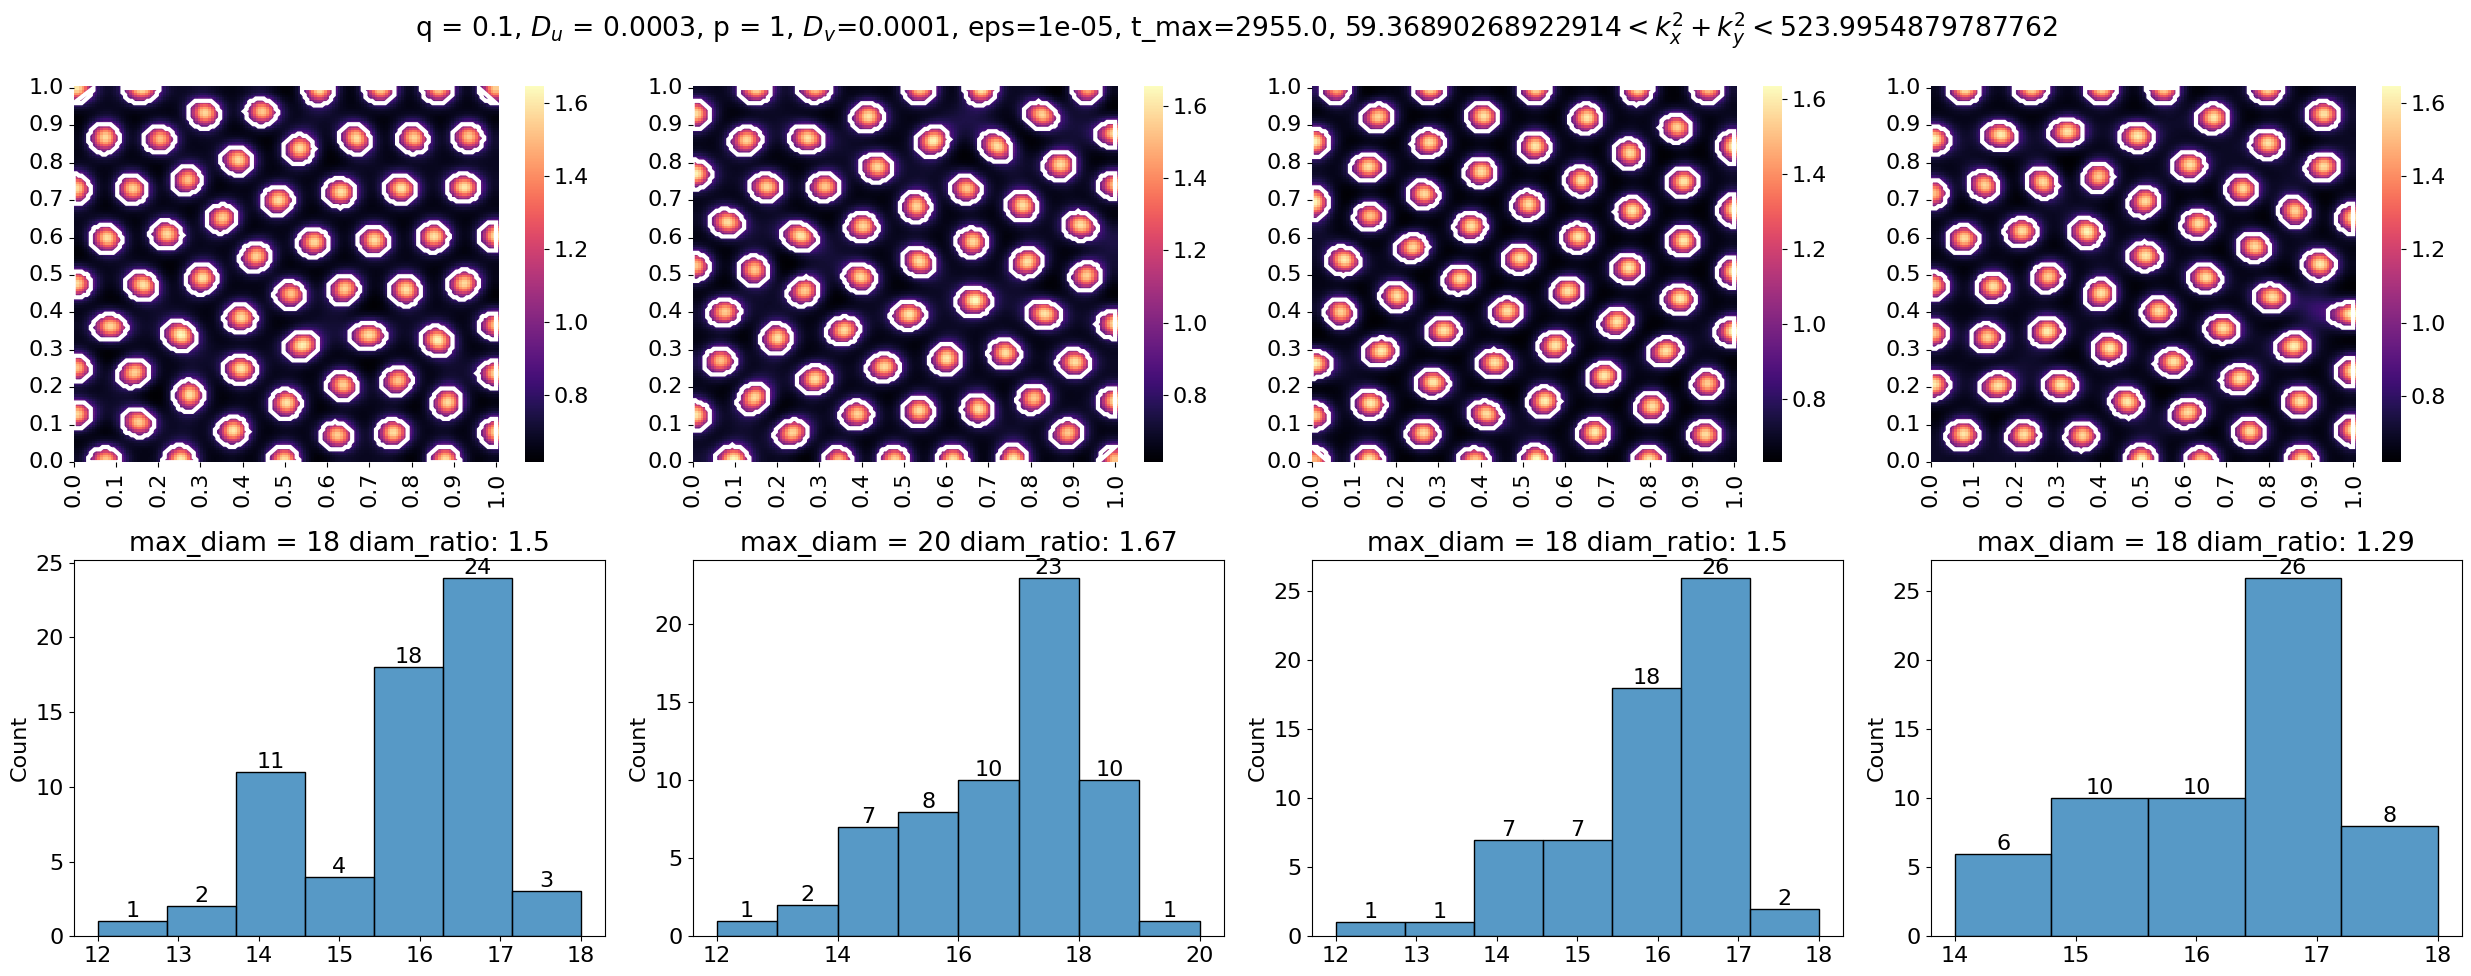

0.1


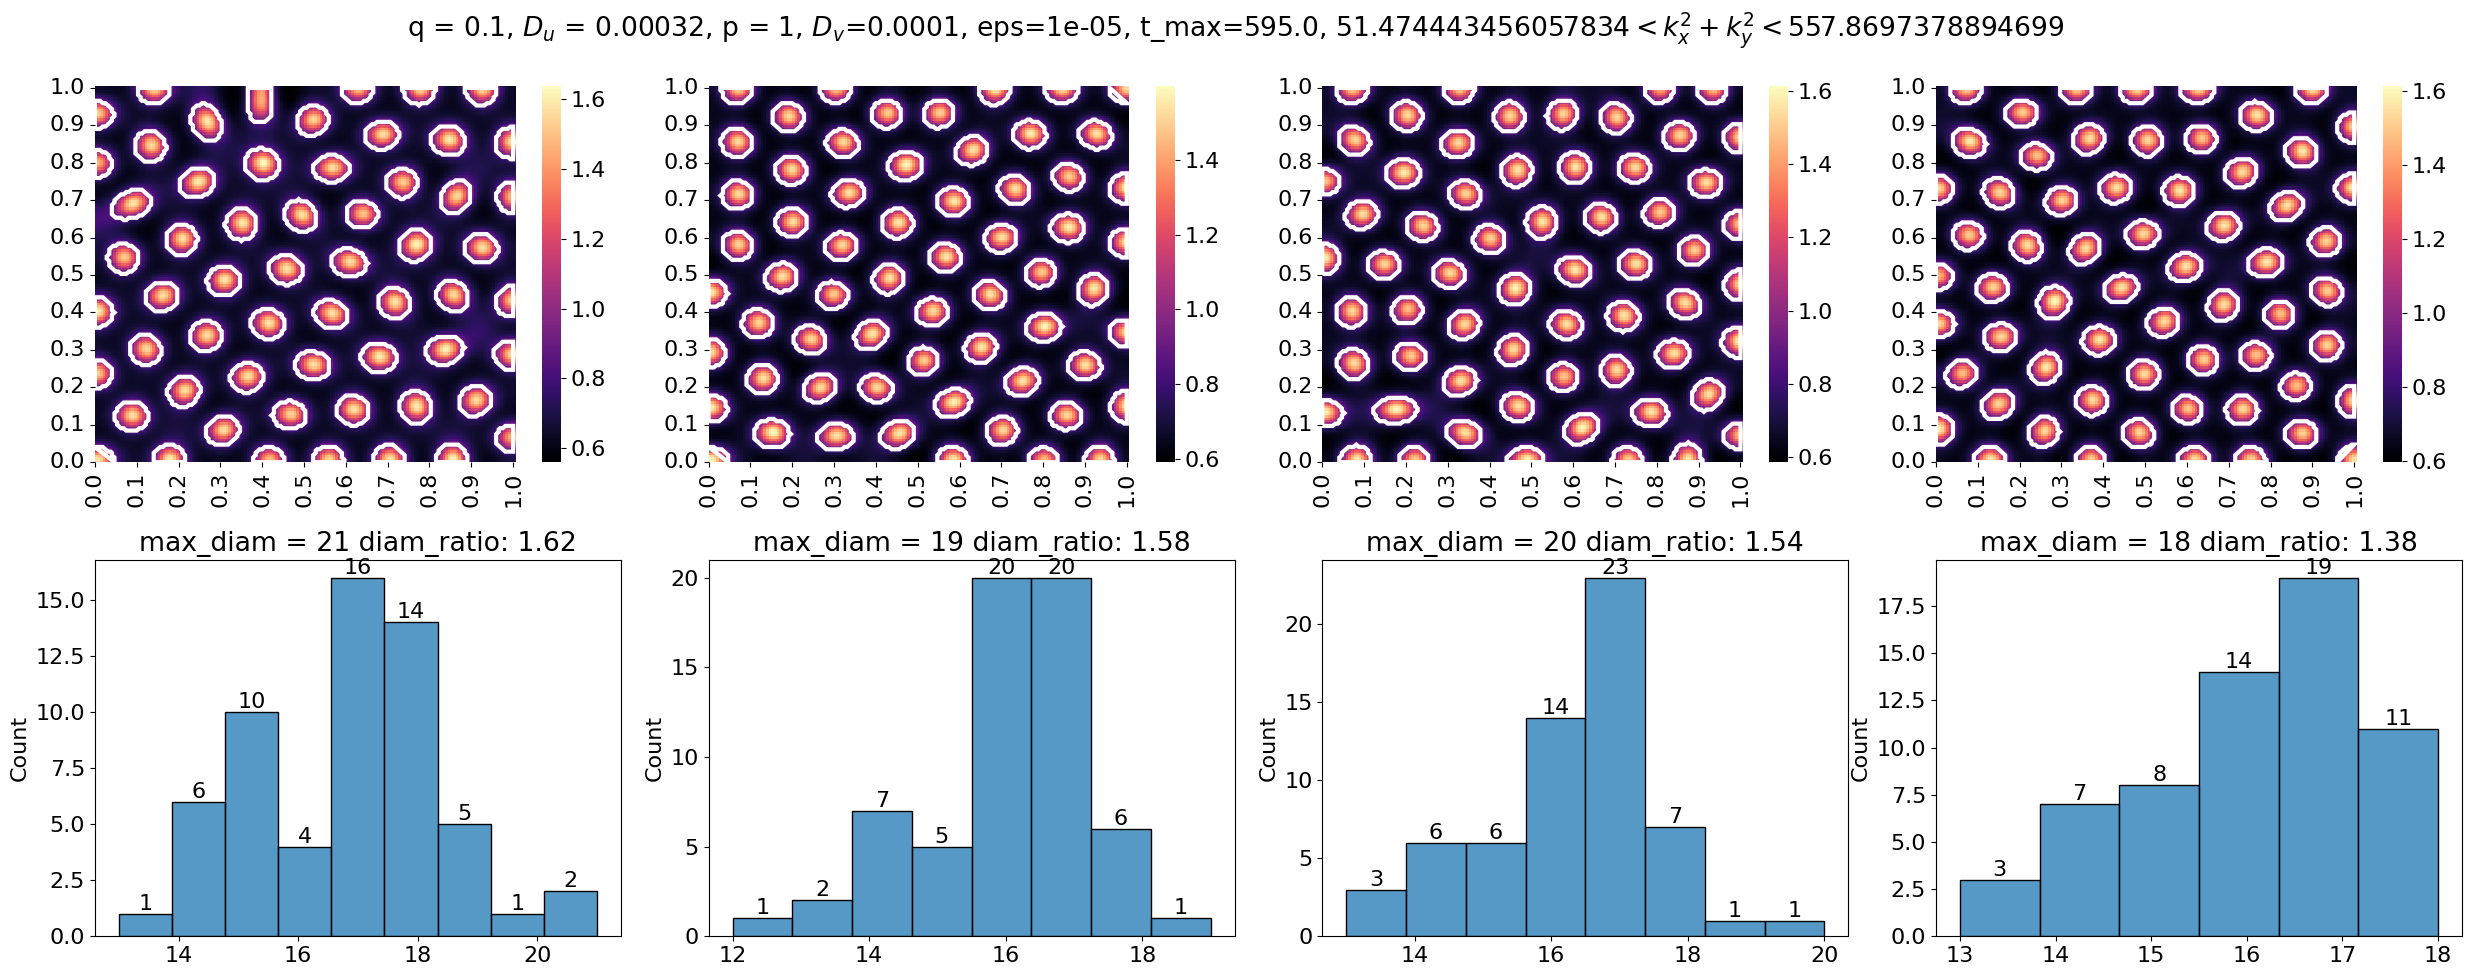

0.1


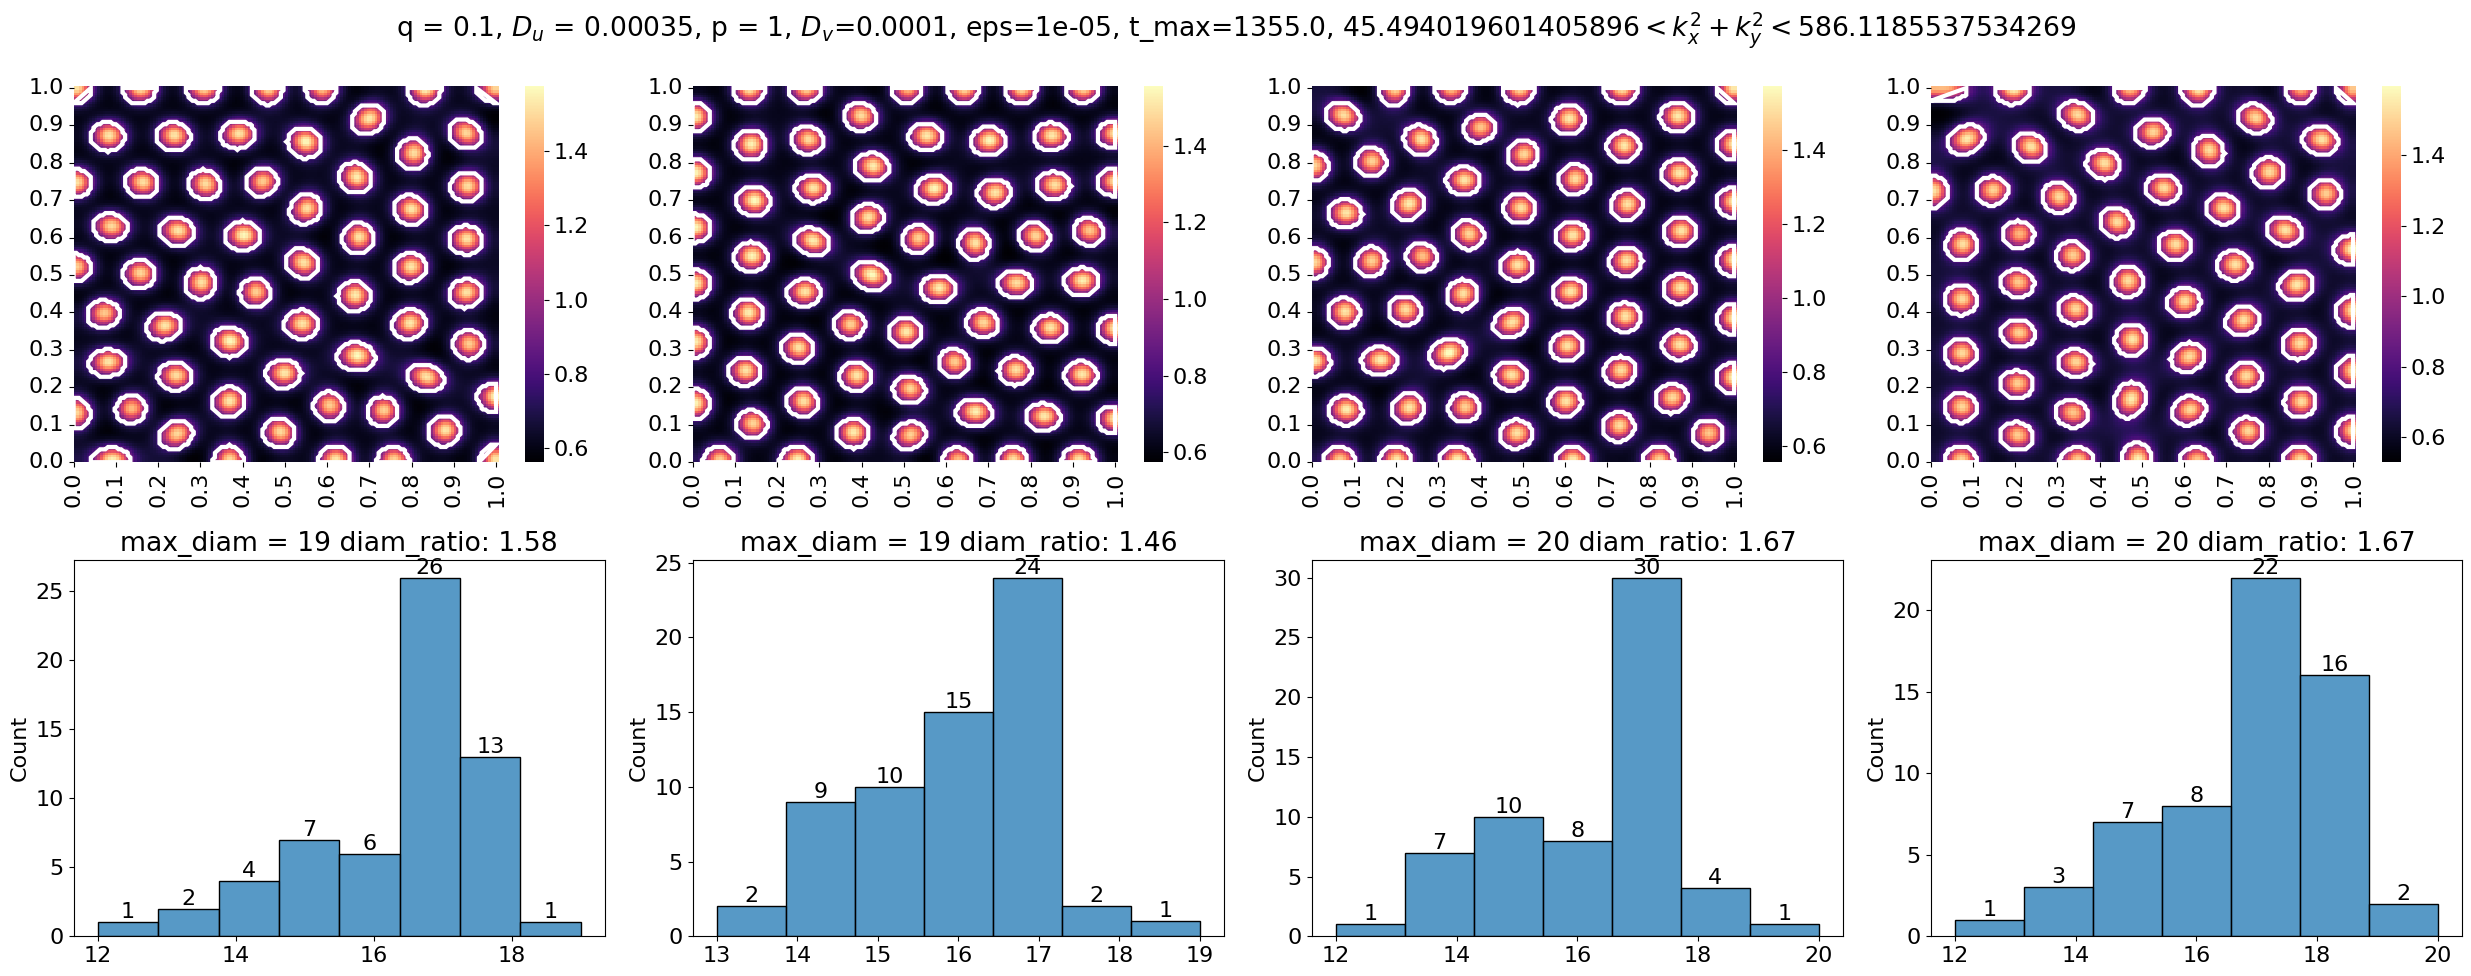

0.1


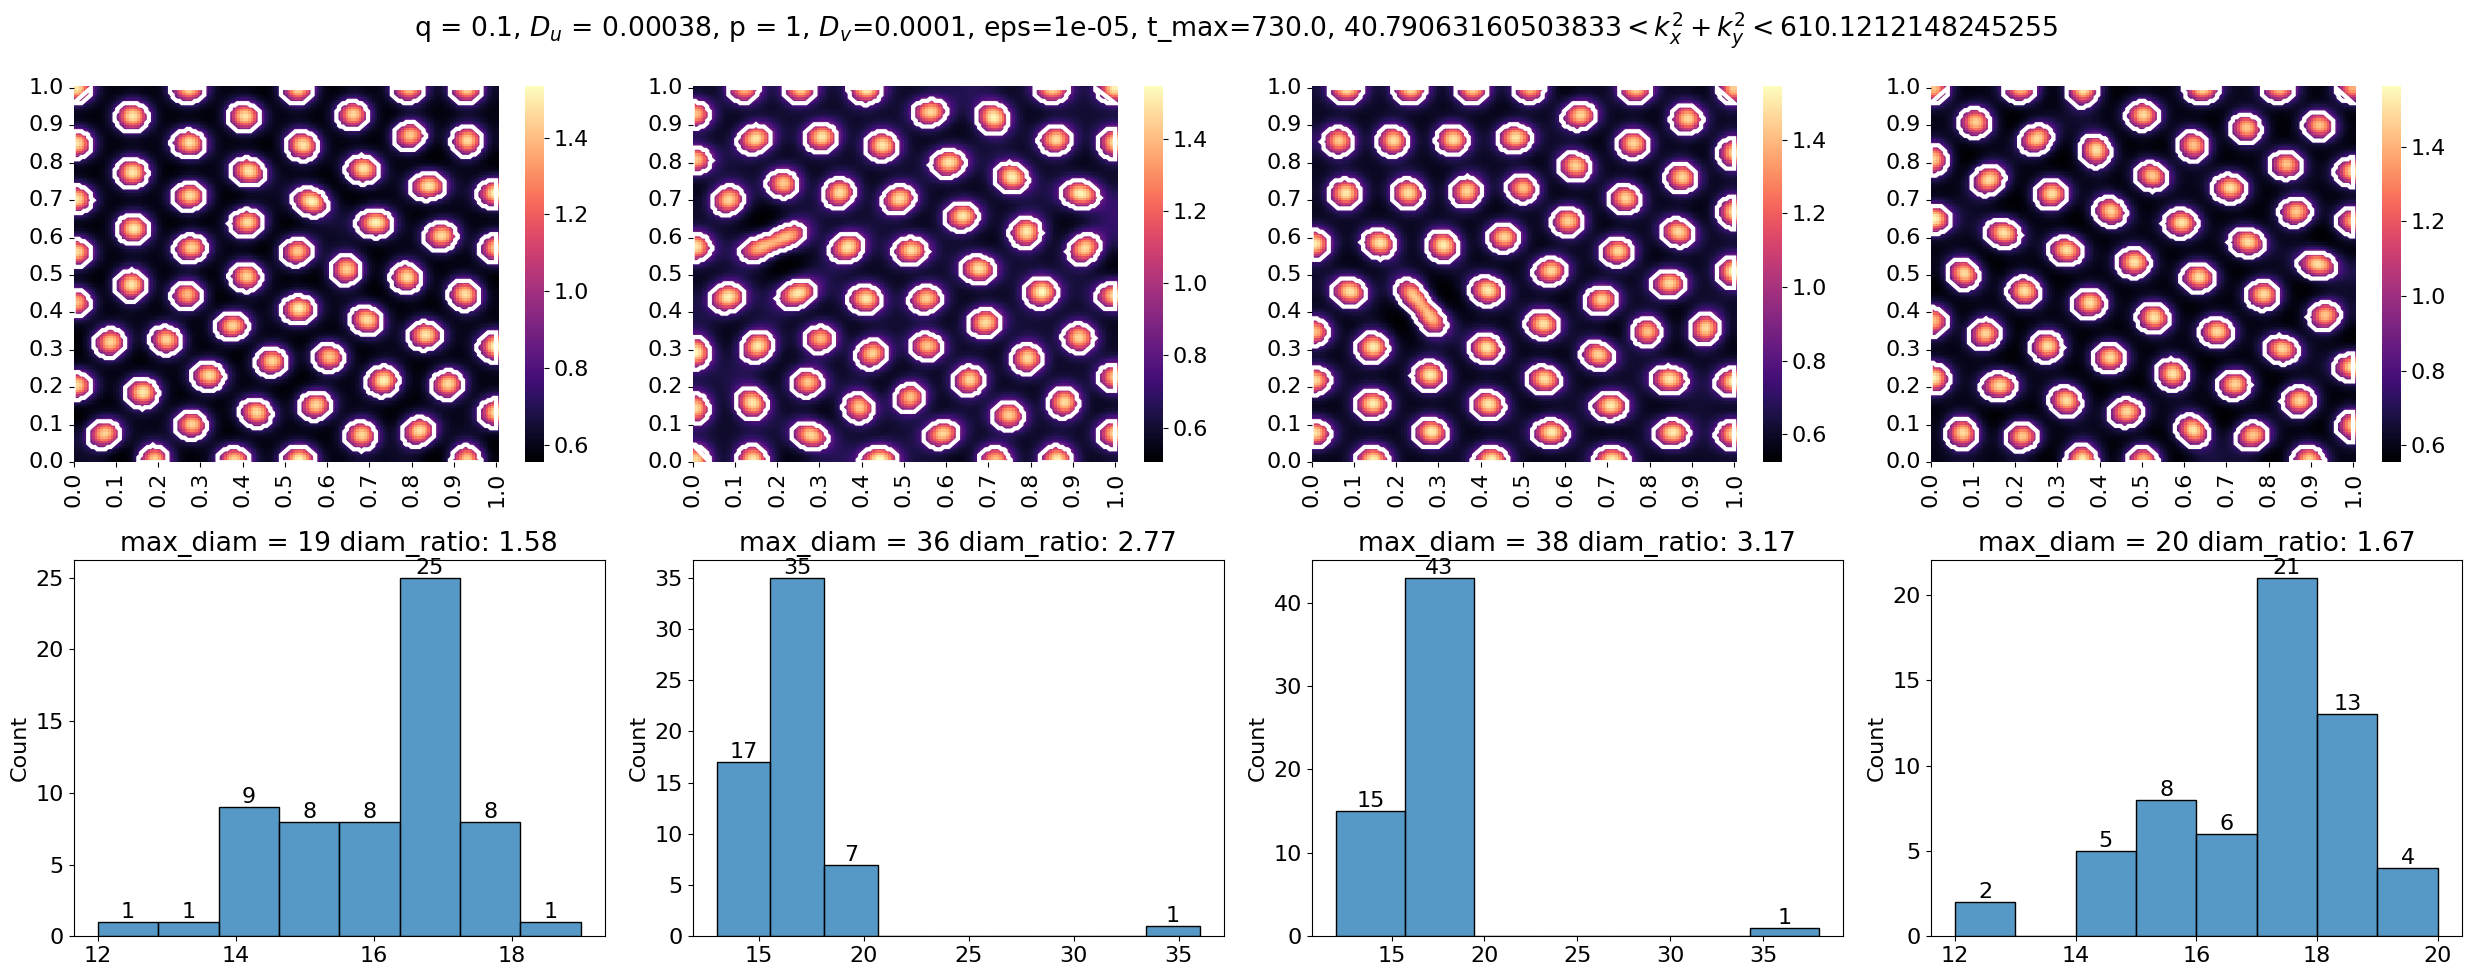

0.1


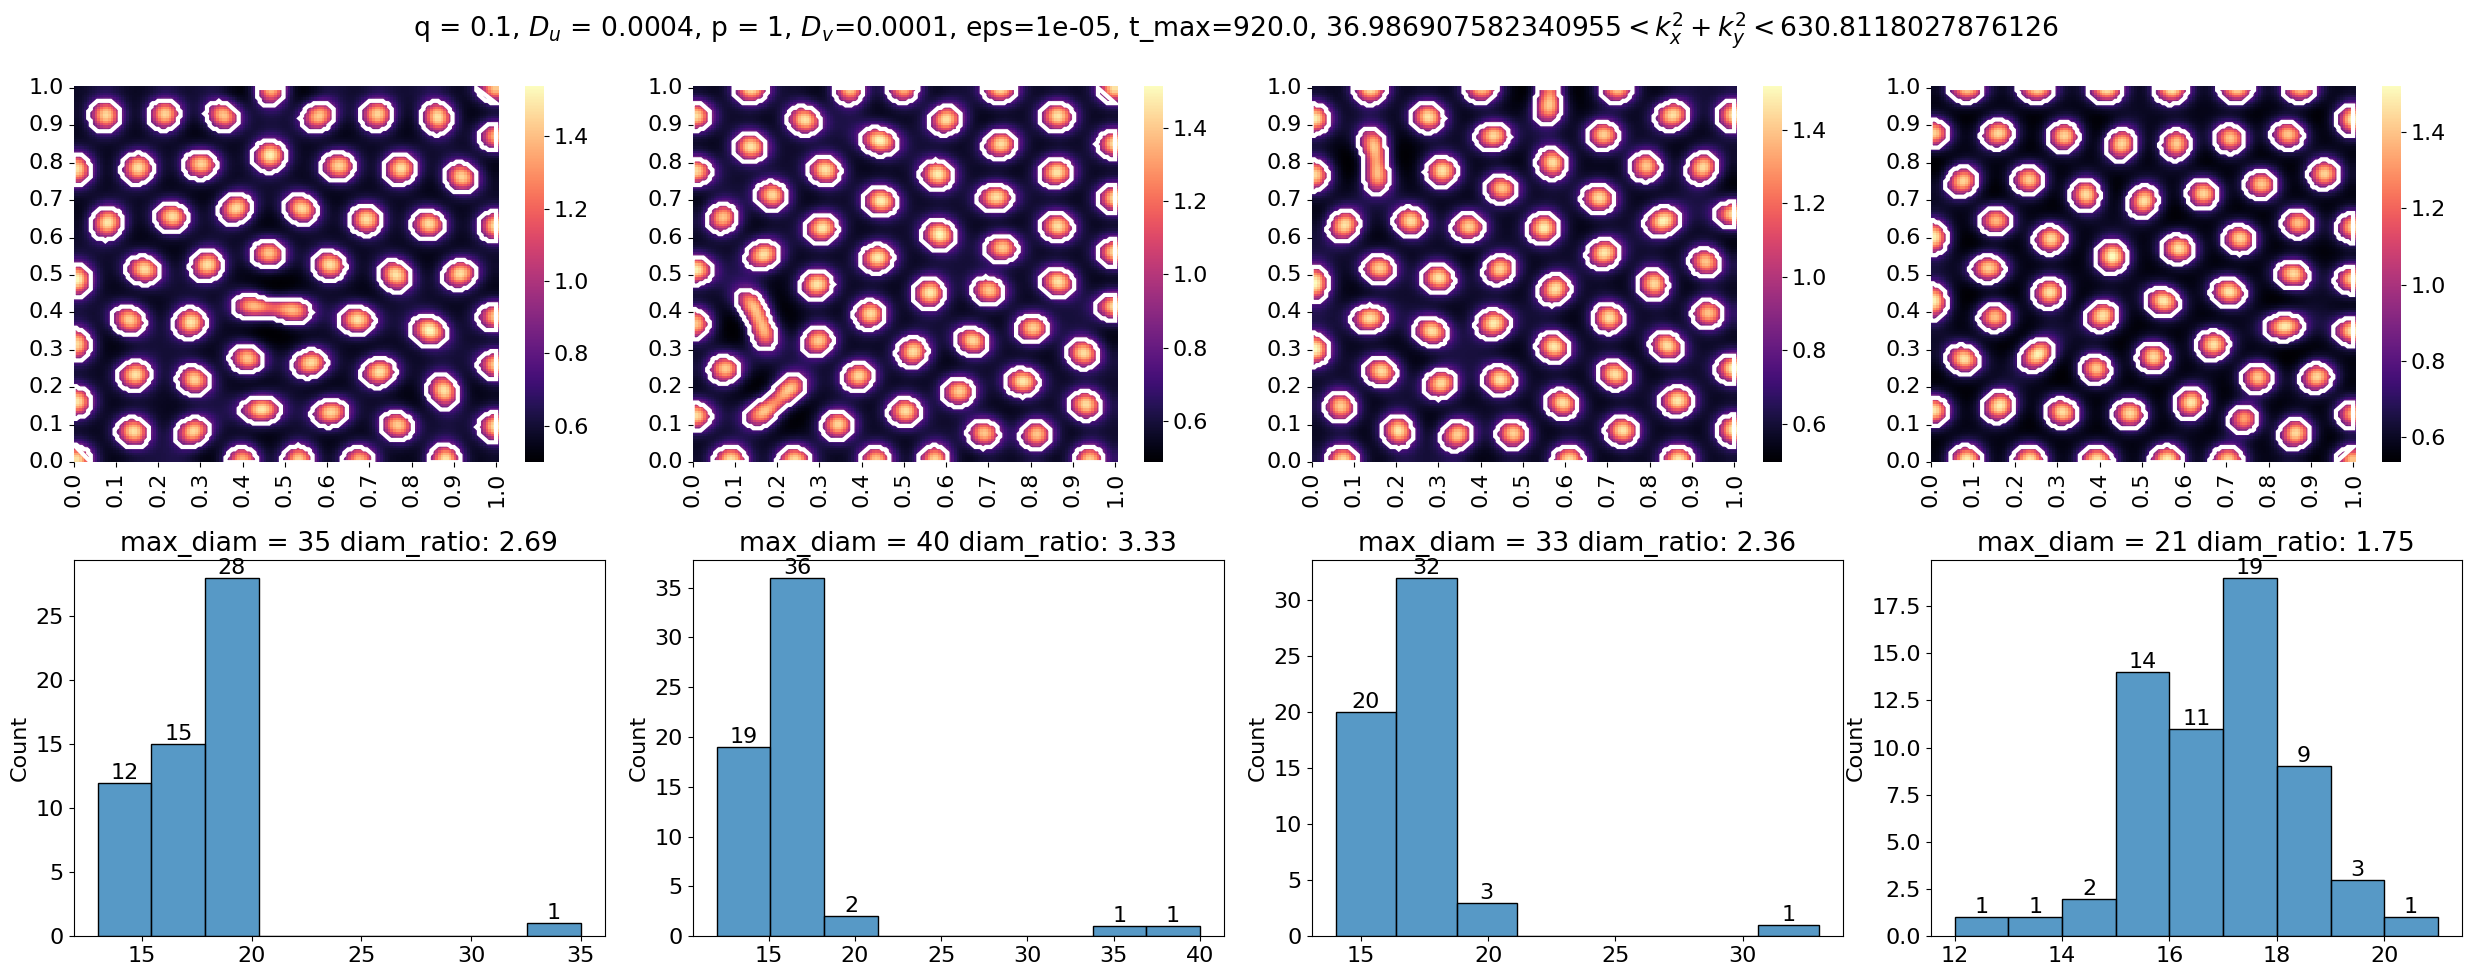

0.1


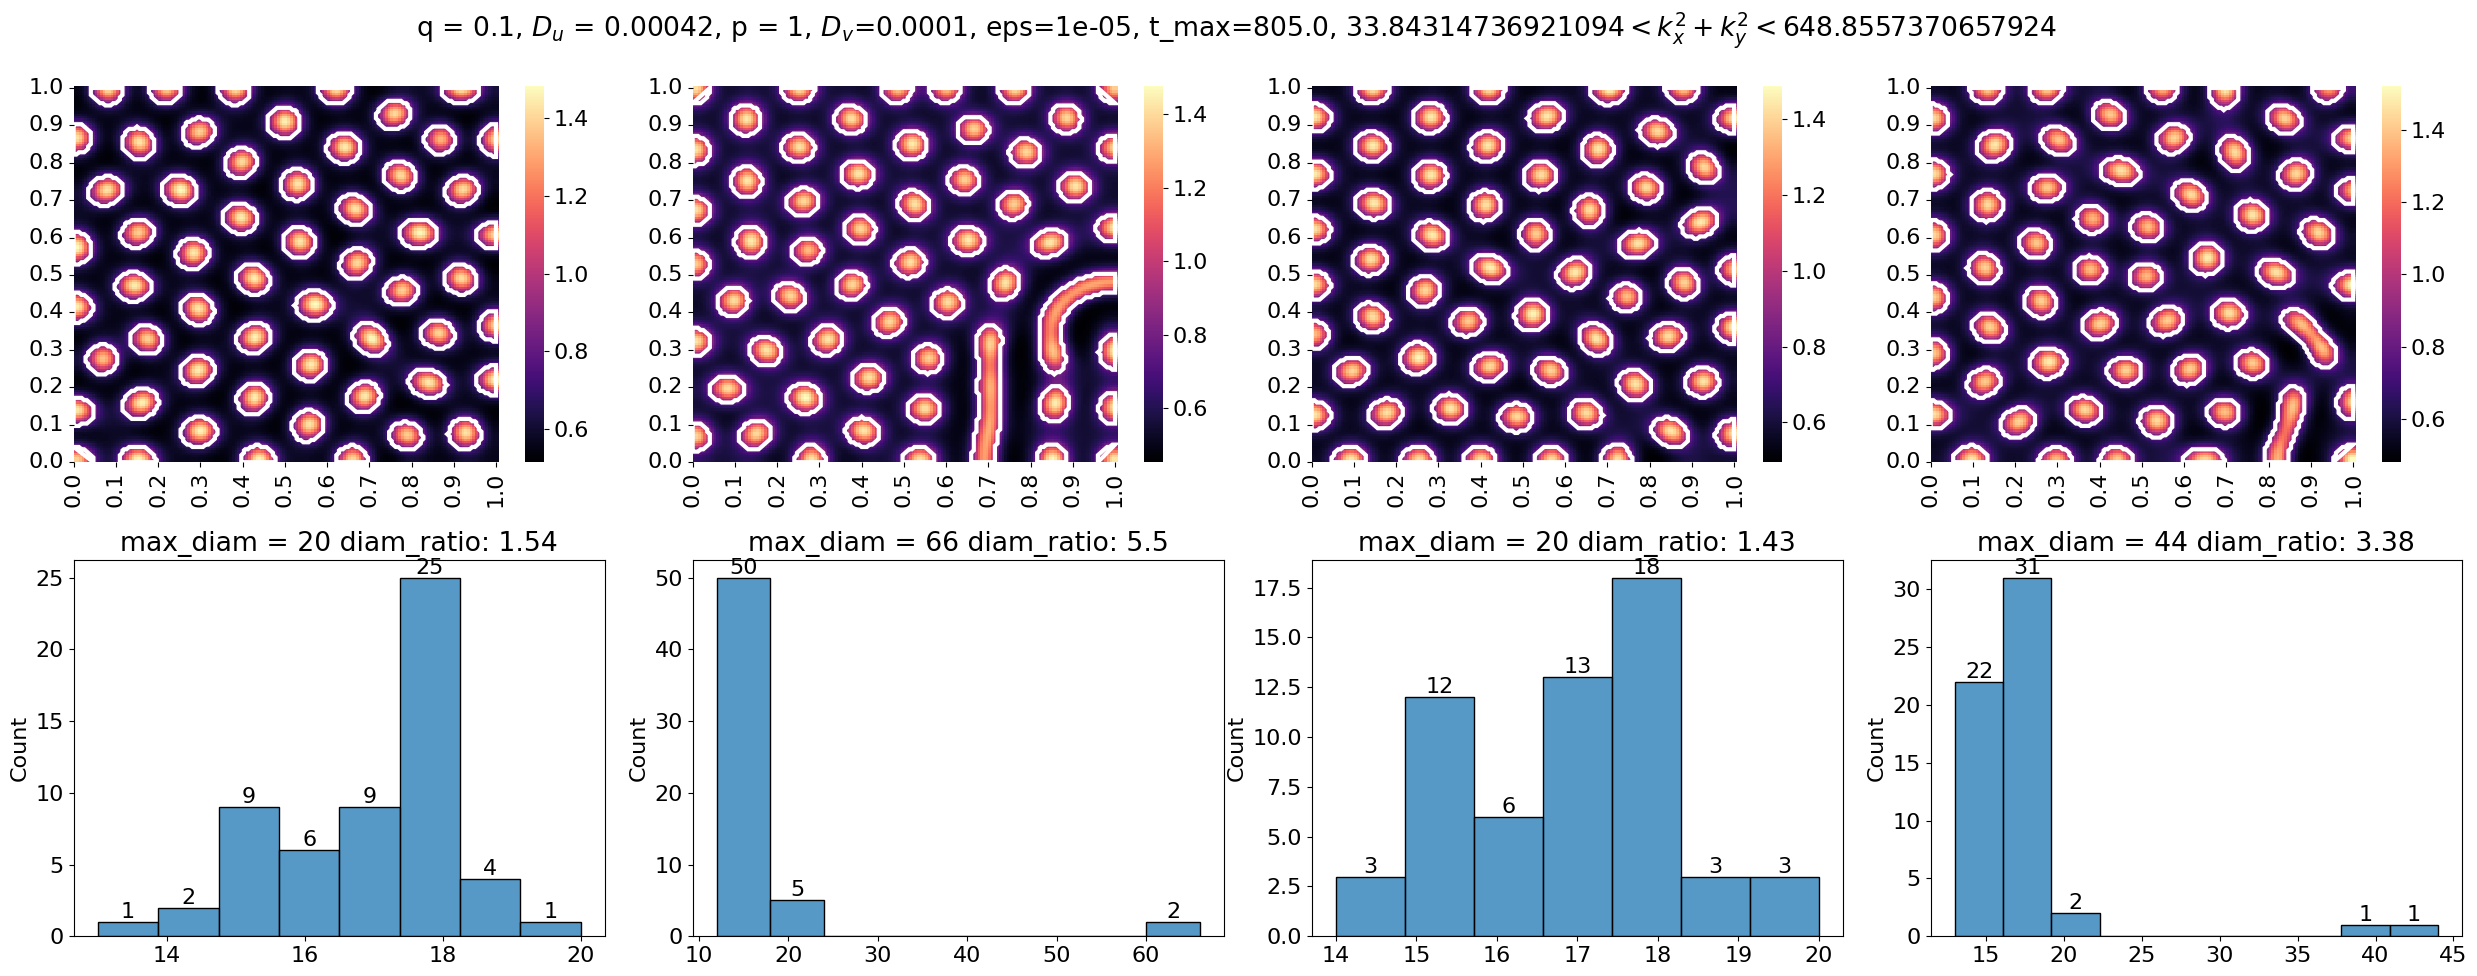

0.1


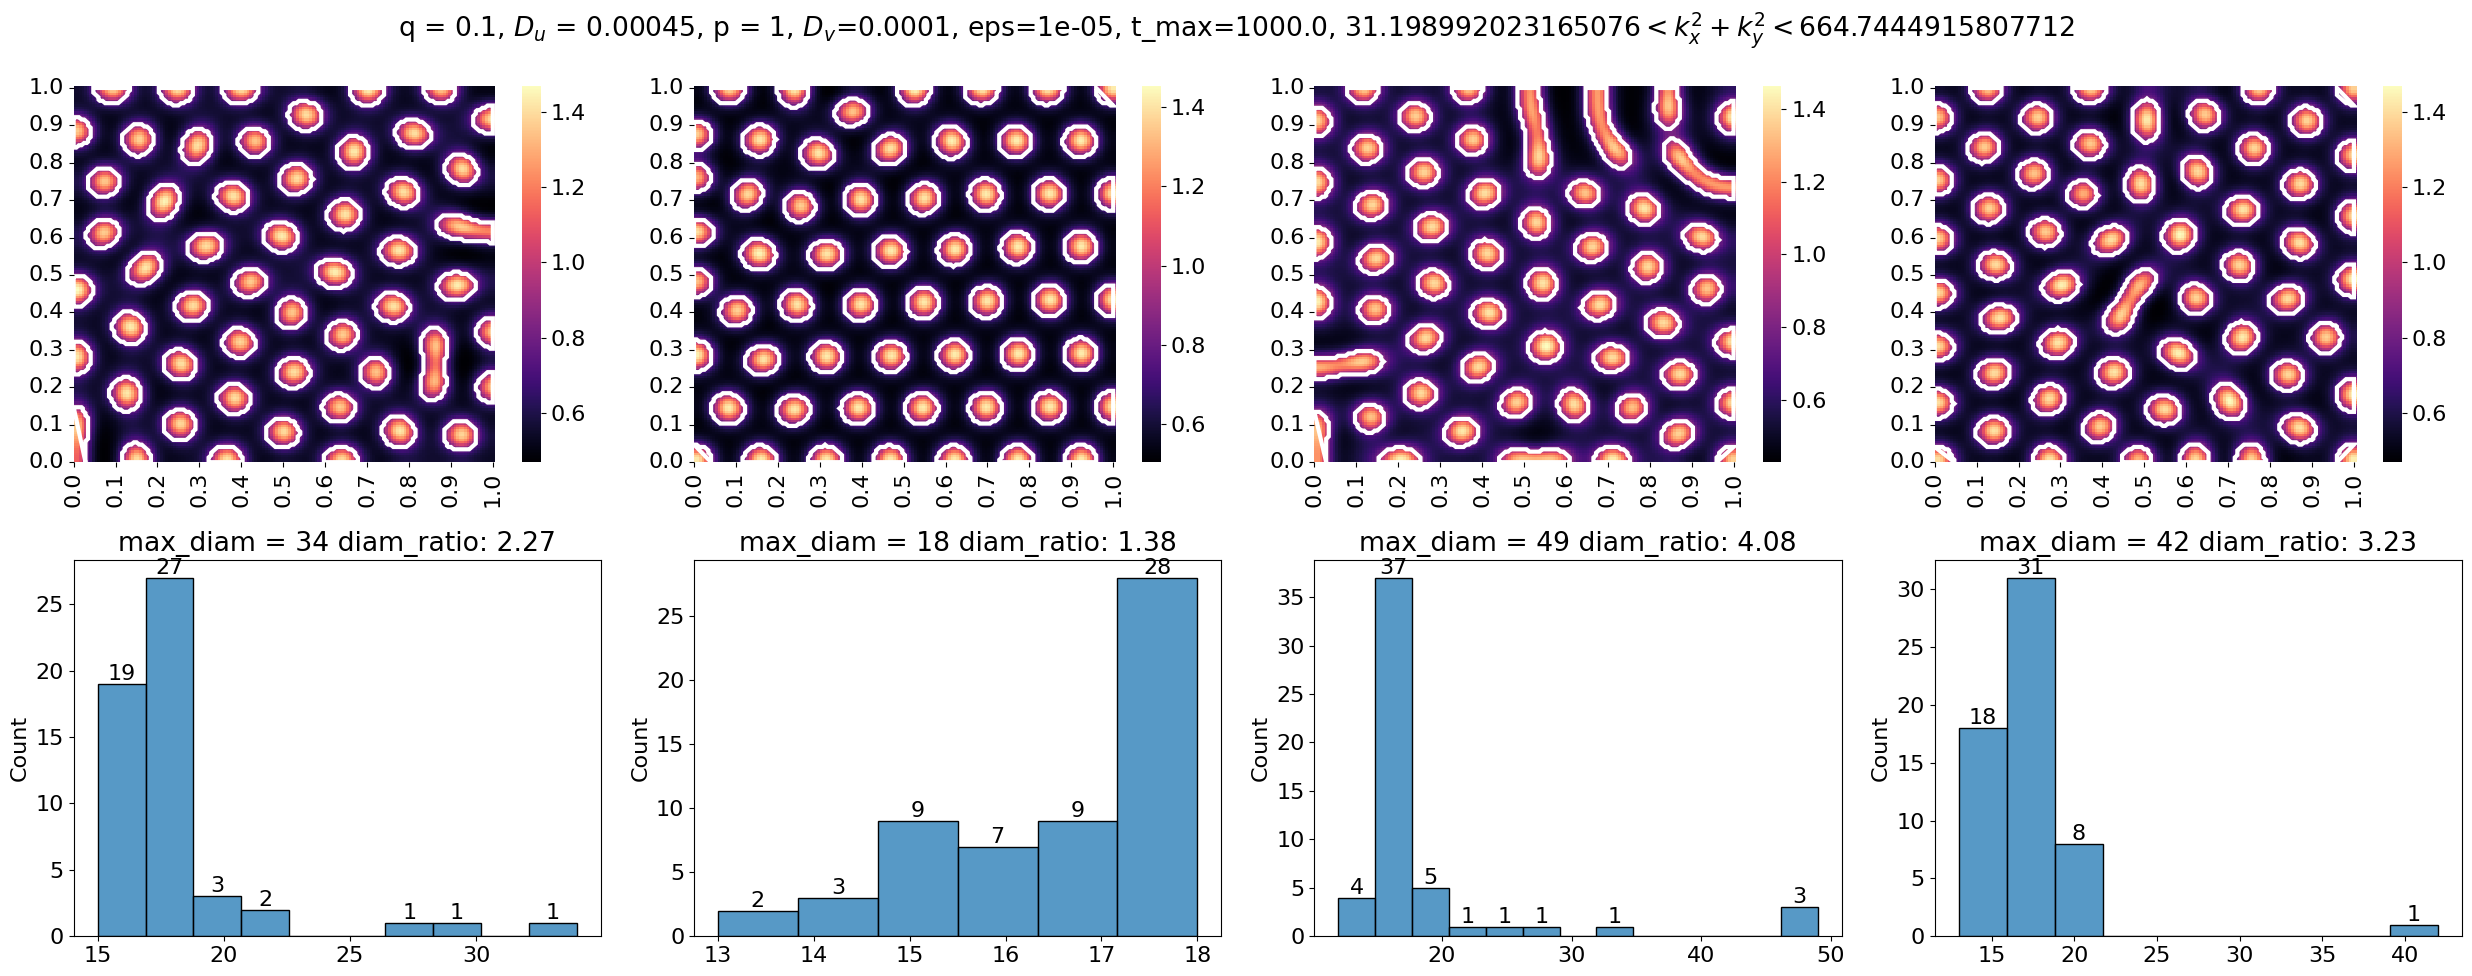

0.1


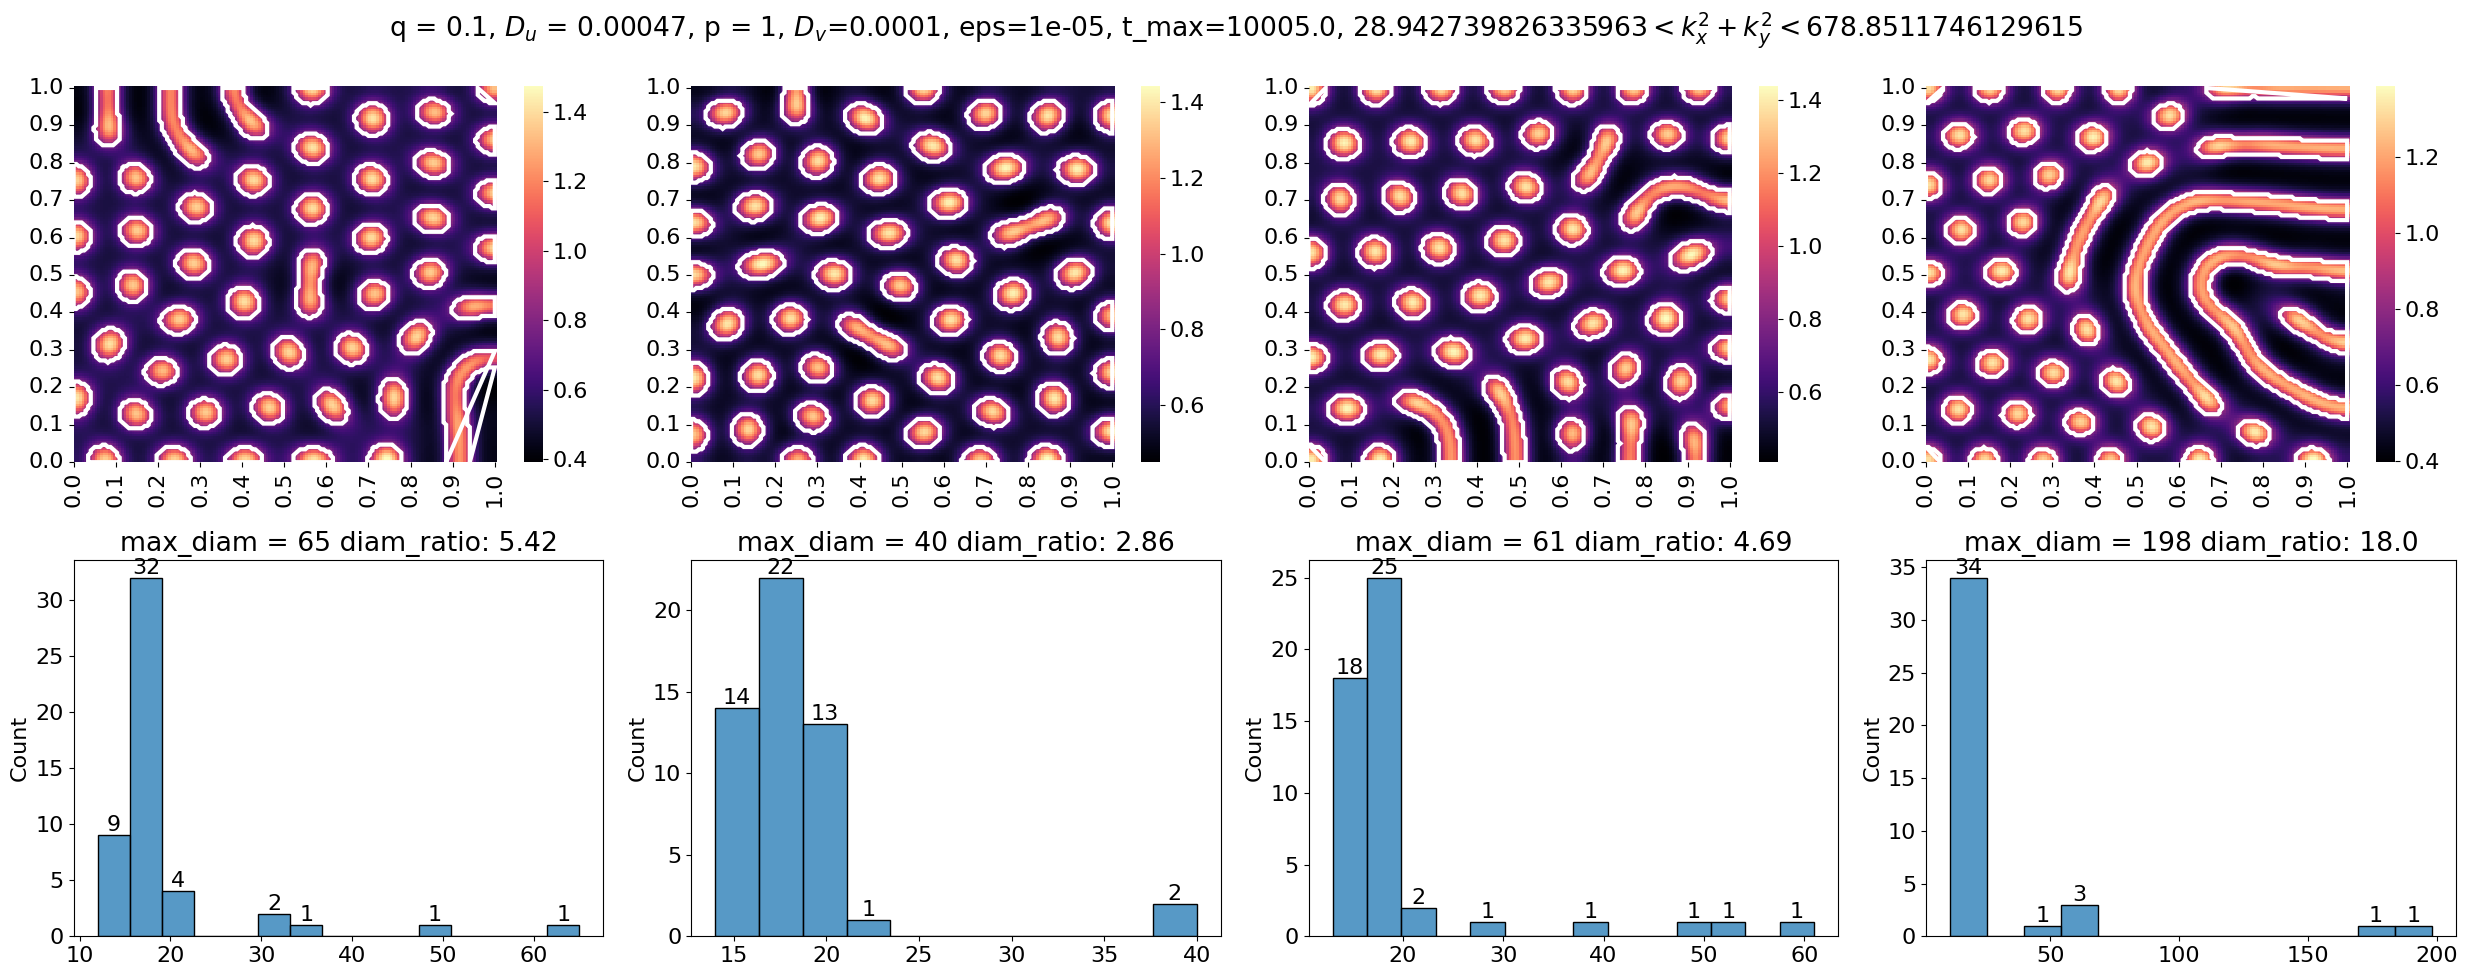

0.1


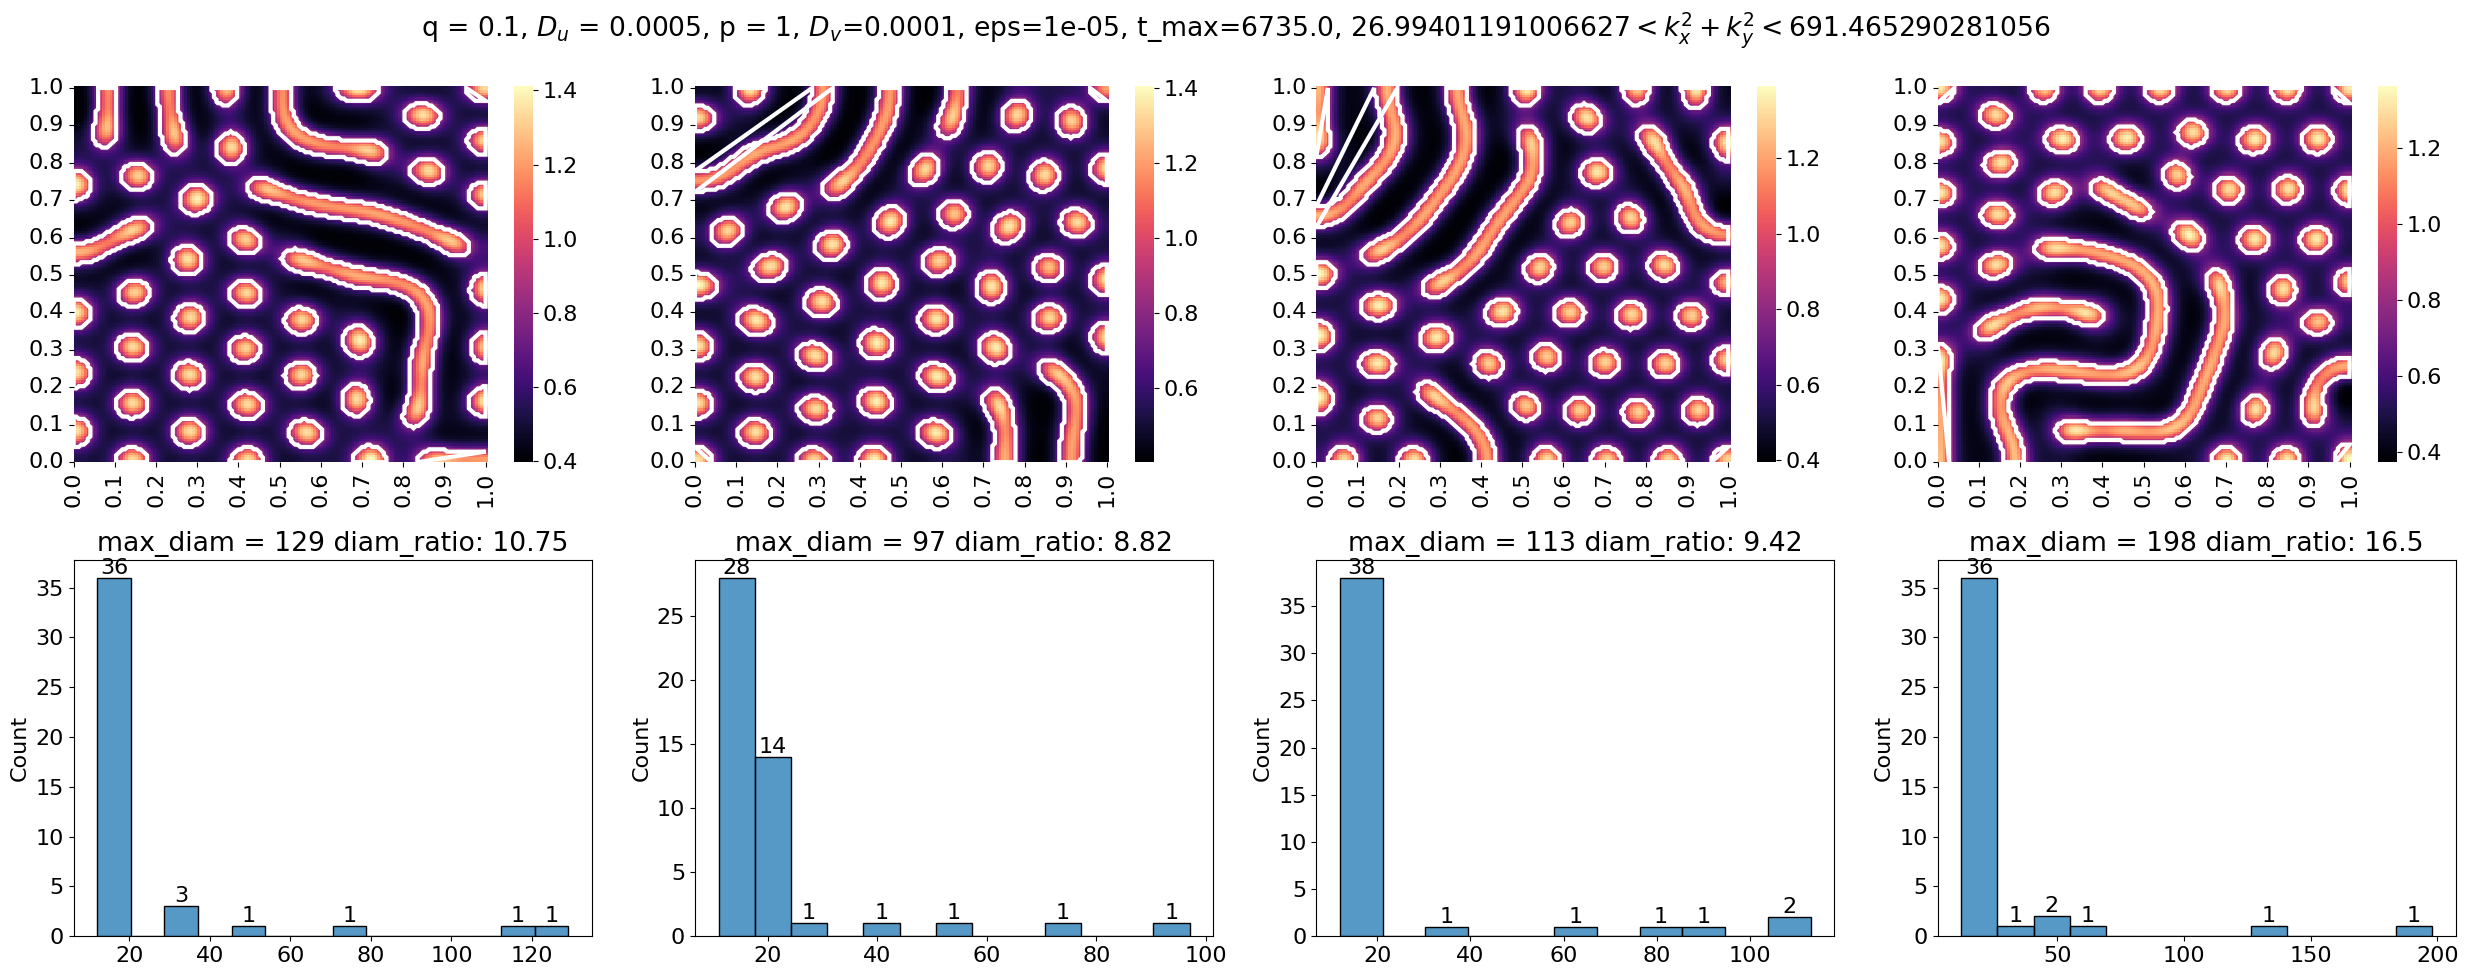

In [204]:
draw_for_q(0.1)

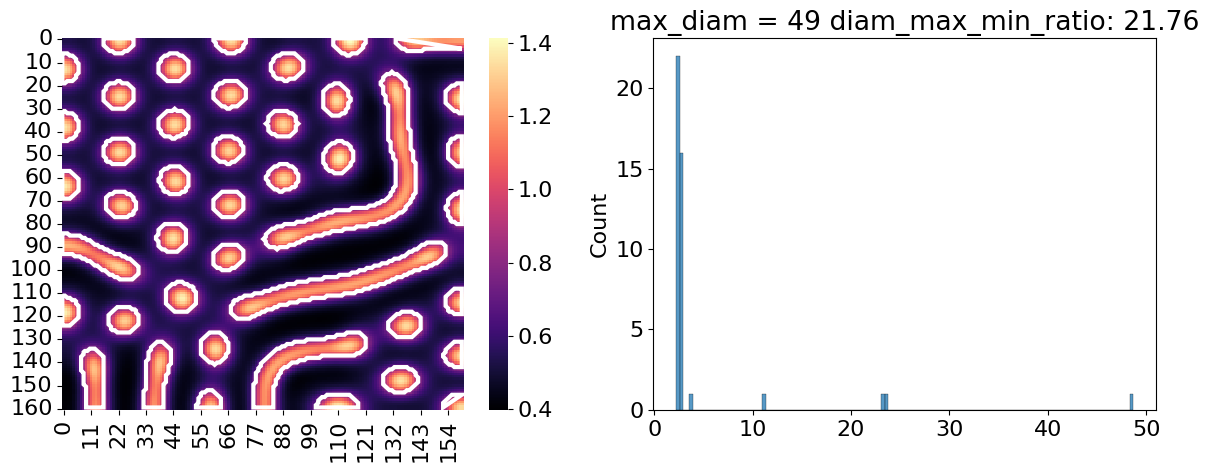

In [205]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
du5_exp = conv[(0.1, 0.0005)][0]
sns.heatmap(du5_exp.process_U[-1], cmap='magma', ax=axes[0])
diams = []
for contour in get_contours(du5_exp):
    polygon = mpatches.Polygon([(y,x) for x,y in contour], closed=True, edgecolor='white', fill=False, lw=3)
    axes[0].add_patch(polygon)
for region in get_regions(du5_exp):
    diams.append(object_diameter(region.image))
sns.histplot(diams, ax=axes[1])
axes[1].set_title(f'max_diam = {round(max(diams))} diam_max_min_ratio: {round(max(diams)/min(diams),2)}')
plt.tight_layout()     
            
plt.show()